#Import Dependencies

In [1]:
import numpy as np

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.layers import Input, Conv1D, Conv1DTranspose, Concatenate, PReLU, LeakyReLU, BatchNormalization, Flatten, Dense

In [4]:
from tensorflow.keras.models import Model

In [5]:
from tensorflow.keras.utils import plot_model

In [6]:
from tensorflow.keras.losses import BinaryCrossentropy

In [7]:
from tensorflow.keras.optimizers import Adam

In [8]:
import librosa

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


In [9]:
import os

In [10]:
import glob

In [11]:
from tqdm.notebook import tqdm

In [12]:
import soundfile as sf

In [13]:
import librosa.display

In [14]:
import matplotlib.pyplot as plt

In [15]:
import datetime

In [16]:
import time

In [17]:
from IPython.display import Audio

In [18]:
from google.colab import drive

#Dataset

In [19]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir 'clean_trainset_wav'
!mkdir 'noisy_trainset_wav'

In [ ]:
!unzip '/content/drive/MyDrive/clean_trainset_wav.zip' -d 'clean_trainset_wav'
!unzip '/content/drive/MyDrive/noisy_trainset_wav.zip' -d 'noisy_trainset_wav'

In [ ]:
!mkdir 'clean_trainset_wav_16k'
!mkdir 'noisy_trainset_wav_16k'

In [23]:
for file in os.listdir('clean_trainset_wav'):
  audio, sr = librosa.load('clean_trainset_wav/'+file, sr=None)
  audio_16k = librosa.resample(y=audio, orig_sr=sr, target_sr=16000)
  sf.write('clean_trainset_wav_16k/'+file, audio_16k, 16000)

In [24]:
for file in os.listdir('noisy_trainset_wav'):
  audio, sr = librosa.load('noisy_trainset_wav/'+file, sr=None)
  audio_16k = librosa.resample(y=audio, orig_sr=sr, target_sr=16000)
  sf.write('noisy_trainset_wav_16k/'+file, audio_16k, 16000)

In [18]:
clean_sounds = glob.glob('/content/clean_trainset_wav_16k/*')
noisy_sounds = glob.glob('/content/noisy_trainset_wav_16k/*')

clean_sounds_list = tf.audio.decode_wav(tf.io.read_file(clean_sounds[0]), desired_channels=1)[0]
for i in tqdm(clean_sounds[1:]):
  s = tf.audio.decode_wav(tf.io.read_file(i), desired_channels=1)[0]
  clean_sounds_list = tf.concat([clean_sounds_list, s], axis=0)

noisy_sounds_list = tf.audio.decode_wav(tf.io.read_file(noisy_sounds[0]), desired_channels=1)[0]
for i in tqdm(noisy_sounds[1:]):
  s = tf.audio.decode_wav(tf.io.read_file(i), desired_channels=1)[0]
  noisy_sounds_list = tf.concat([noisy_sounds_list, s], axis=0)

print(clean_sounds_list.shape)
print(noisy_sounds_list.shape)

  0%|          | 0/11571 [00:00<?, ?it/s]

  0%|          | 0/11571 [00:00<?, ?it/s]

(540938091, 1)
(540938091, 1)


In [19]:
BATCH_SIZE = 16384

clean_train, noisy_train = [], []

for i in tqdm(range(0, clean_sounds_list.shape[0]*9//10-BATCH_SIZE, BATCH_SIZE)):
  clean_train.append(clean_sounds_list[i:i+BATCH_SIZE])
  noisy_train.append(noisy_sounds_list[i:i+BATCH_SIZE])

clean_train = tf.stack(clean_train)
noisy_train = tf.stack(noisy_train)

print(clean_train.shape)
print(noisy_train.shape)

  0%|          | 0/29714 [00:00<?, ?it/s]

(29714, 16384, 1)
(29714, 16384, 1)


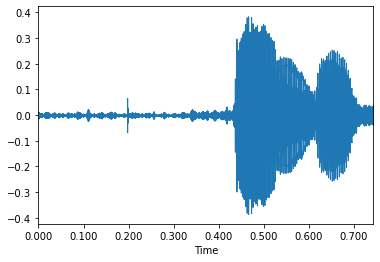

In [20]:
librosa.display.waveplot(np.squeeze(clean_train[0].numpy(), axis=-1))
plt.show()

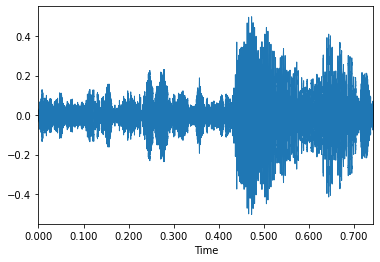

In [21]:
librosa.display.waveplot(np.squeeze(noisy_train[0].numpy(), axis=-1))
plt.show()

In [22]:
def get_dataset(X_train, y_train):
  dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
  dataset = dataset.shuffle(100).batch(64, drop_remainder=True)
  return dataset

In [23]:
train_dataset = get_dataset(noisy_train[:26000], clean_train[:26000])
test_dataset = get_dataset(noisy_train[26000:], clean_train[26000:])

#Model

##Generator

In [31]:
# #Input layer : Noisy signal
# input = Input(shape=(BATCH_SIZE,1))     #BATCH_SIZE=16384

# #Encoder stage : 11 convolutional layers each with filter width = 31 and strides = 2 followed by PReLU activation
# c1 = Conv1D(filters=16, kernel_size=31, strides=2, padding='same')(input)
# c1a = PReLU()(c1)

# c2 = Conv1D(filters=32, kernel_size=31, strides=2, padding='same')(c1a)
# c2a = PReLU()(c2)

# c3 = Conv1D(filters=32, kernel_size=31, strides=2, padding='same')(c2a)
# c3a = PReLU()(c3)

# c4 = Conv1D(filters=64, kernel_size=31, strides=2, padding='same')(c3a)
# c4a = PReLU()(c4)

# c5 = Conv1D(filters=64, kernel_size=31, strides=2, padding='same')(c4a)
# c5a = PReLU()(c5)

# c6 = Conv1D(filters=128, kernel_size=31, strides=2, padding='same')(c5a)
# c6a = PReLU()(c6)

# c7 = Conv1D(filters=128, kernel_size=31, strides=2, padding='same')(c6a)
# c7a = PReLU()(c7)

# c8 = Conv1D(filters=256, kernel_size=31, strides=2, padding='same')(c7a)
# c8a = PReLU()(c8)

# c9 = Conv1D(filters=256, kernel_size=31, strides=2, padding='same')(c8a)
# c9a = PReLU()(c9)

# c10 = Conv1D(filters=512, kernel_size=31, strides=2, padding='same')(c9a)
# c10a = PReLU()(c10)

# c11 = Conv1D(filters=1024, kernel_size=31, strides=2, padding='same')(c10a)
# c11a = PReLU()(c11)

# #c11a is the thought vector
# #It will be concatenated with the latent vector z that comes from an 8x1024 dimensional standard normal distribution
# z = Input(shape=(BATCH_SIZE//(2**11),1024))
# cz = Concatenate()([c11a,z])

# #Decoder stage : 11 deconvolutional PReLU activated layers, each concatenated with its convolutional counterpart from the encoder stage
# dc1 = Conv1DTranspose(filters=1024, kernel_size=31, strides=1, padding='same')(cz)
# dc1a = PReLU()(dc1)
# conc1 = Concatenate()([dc1a,c11a])

# dc2 = Conv1DTranspose(filters=512, kernel_size=31, strides=2, padding='same')(conc1)
# dc2a = PReLU()(dc2)
# conc2 = Concatenate()([dc2a,c10a])

# dc3 = Conv1DTranspose(filters=256, kernel_size=31, strides=2, padding='same')(conc2)
# dc3a = PReLU()(dc3)
# conc3 = Concatenate()([dc3a,c9a])

# dc4 = Conv1DTranspose(filters=256, kernel_size=31, strides=2, padding='same')(conc3)
# dc4a = PReLU()(dc4)
# conc4 = Concatenate()([dc4a,c8a])

# dc5 = Conv1DTranspose(filters=128, kernel_size=31, strides=2, padding='same')(conc4)
# dc5a = PReLU()(dc5)
# conc5 = Concatenate()([dc5a,c7a])

# dc6 = Conv1DTranspose(filters=128, kernel_size=31, strides=2, padding='same')(conc5)
# dc6a = PReLU()(dc6)
# conc6 = Concatenate()([dc6a,c6a])

# dc7 = Conv1DTranspose(filters=64, kernel_size=31, strides=2, padding='same')(conc6)
# dc7a = PReLU()(dc7)
# conc7 = Concatenate()([dc7a,c5a])

# dc8 = Conv1DTranspose(filters=64, kernel_size=31, strides=2, padding='same')(conc7)
# dc8a = PReLU()(dc8)
# conc8 = Concatenate()([dc8a,c4a])

# dc9 = Conv1DTranspose(filters=32, kernel_size=31, strides=2, padding='same')(conc8)
# dc9a = PReLU()(dc9)
# conc9 = Concatenate()([dc9a,c3a])

# dc10 = Conv1DTranspose(filters=32, kernel_size=31, strides=2, padding='same')(conc9)
# dc10a = PReLU()(dc10)
# conc10 = Concatenate()([dc10a,c2a])

# dc11 = Conv1DTranspose(filters=16, kernel_size=31, strides=2, padding='same')(conc10)
# dc11a = PReLU()(dc11)
# conc11 = Concatenate()([dc11a,c1a])

# #Output layer
# g_output = Conv1DTranspose(filters=1, kernel_size=31, strides=2, padding='same')(conc11)

# #Generator model
# generator = Model(inputs=[input, z], outputs=g_output)

In [24]:
#Input layer : Noisy signal
input = Input(shape=(BATCH_SIZE,1))     #BATCH_SIZE=16384

#Encoder stage : 11 convolutional layers each with filter width = 31 and strides = 2 followed by PReLU activation
c1 = Conv1D(filters=16, kernel_size=31, strides=2, padding='same')(input)
c1a = PReLU()(c1)

c2 = Conv1D(filters=32, kernel_size=31, strides=2, padding='same')(c1a)
c2a = PReLU()(c2)

c3 = Conv1D(filters=32, kernel_size=31, strides=2, padding='same')(c2a)
c3a = PReLU()(c3)

c4 = Conv1D(filters=64, kernel_size=31, strides=2, padding='same')(c3a)
c4a = PReLU()(c4)

c5 = Conv1D(filters=64, kernel_size=31, strides=2, padding='same')(c4a)
c5a = PReLU()(c5)

c6 = Conv1D(filters=128, kernel_size=31, strides=2, padding='same')(c5a)
c6a = PReLU()(c6)

c7 = Conv1D(filters=128, kernel_size=31, strides=2, padding='same')(c6a)
c7a = PReLU()(c7)

c8 = Conv1D(filters=256, kernel_size=31, strides=2, padding='same')(c7a)
c8a = PReLU()(c8)

c9 = Conv1D(filters=256, kernel_size=31, strides=2, padding='same')(c8a)
c9a = PReLU()(c9)

c10 = Conv1D(filters=512, kernel_size=31, strides=2, padding='same')(c9a)
c10a = PReLU()(c10)

c11 = Conv1D(filters=1024, kernel_size=31, strides=2, padding='same')(c10a)
c11a = PReLU()(c11)

#Decoder stage : 11 deconvolutional PReLU activated layers, each concatenated with its convolutional counterpart from the encoder stage
dc1 = Conv1DTranspose(filters=1024, kernel_size=31, strides=1, padding='same')(c11a)
dc1a = PReLU()(dc1)
conc1 = Concatenate()([dc1a,c11a])

dc2 = Conv1DTranspose(filters=512, kernel_size=31, strides=2, padding='same')(conc1)
dc2a = PReLU()(dc2)
conc2 = Concatenate()([dc2a,c10a])

dc3 = Conv1DTranspose(filters=256, kernel_size=31, strides=2, padding='same')(conc2)
dc3a = PReLU()(dc3)
conc3 = Concatenate()([dc3a,c9a])

dc4 = Conv1DTranspose(filters=256, kernel_size=31, strides=2, padding='same')(conc3)
dc4a = PReLU()(dc4)
conc4 = Concatenate()([dc4a,c8a])

dc5 = Conv1DTranspose(filters=128, kernel_size=31, strides=2, padding='same')(conc4)
dc5a = PReLU()(dc5)
conc5 = Concatenate()([dc5a,c7a])

dc6 = Conv1DTranspose(filters=128, kernel_size=31, strides=2, padding='same')(conc5)
dc6a = PReLU()(dc6)
conc6 = Concatenate()([dc6a,c6a])

dc7 = Conv1DTranspose(filters=64, kernel_size=31, strides=2, padding='same')(conc6)
dc7a = PReLU()(dc7)
conc7 = Concatenate()([dc7a,c5a])

dc8 = Conv1DTranspose(filters=64, kernel_size=31, strides=2, padding='same')(conc7)
dc8a = PReLU()(dc8)
conc8 = Concatenate()([dc8a,c4a])

dc9 = Conv1DTranspose(filters=32, kernel_size=31, strides=2, padding='same')(conc8)
dc9a = PReLU()(dc9)
conc9 = Concatenate()([dc9a,c3a])

dc10 = Conv1DTranspose(filters=32, kernel_size=31, strides=2, padding='same')(conc9)
dc10a = PReLU()(dc10)
conc10 = Concatenate()([dc10a,c2a])

dc11 = Conv1DTranspose(filters=16, kernel_size=31, strides=2, padding='same')(conc10)
dc11a = PReLU()(dc11)
conc11 = Concatenate()([dc11a,c1a])

#Output layer
g_output = Conv1DTranspose(filters=1, kernel_size=31, strides=2, padding='same')(conc11)

#Generator model
generator = Model(inputs=input, outputs=g_output)

In [25]:
#Summarize the model
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16384, 1)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 8192, 16)     512         ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 8192, 16)     131072      ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 4096, 32)     15904       ['p_re_lu[0][0]']                
                                                                                              

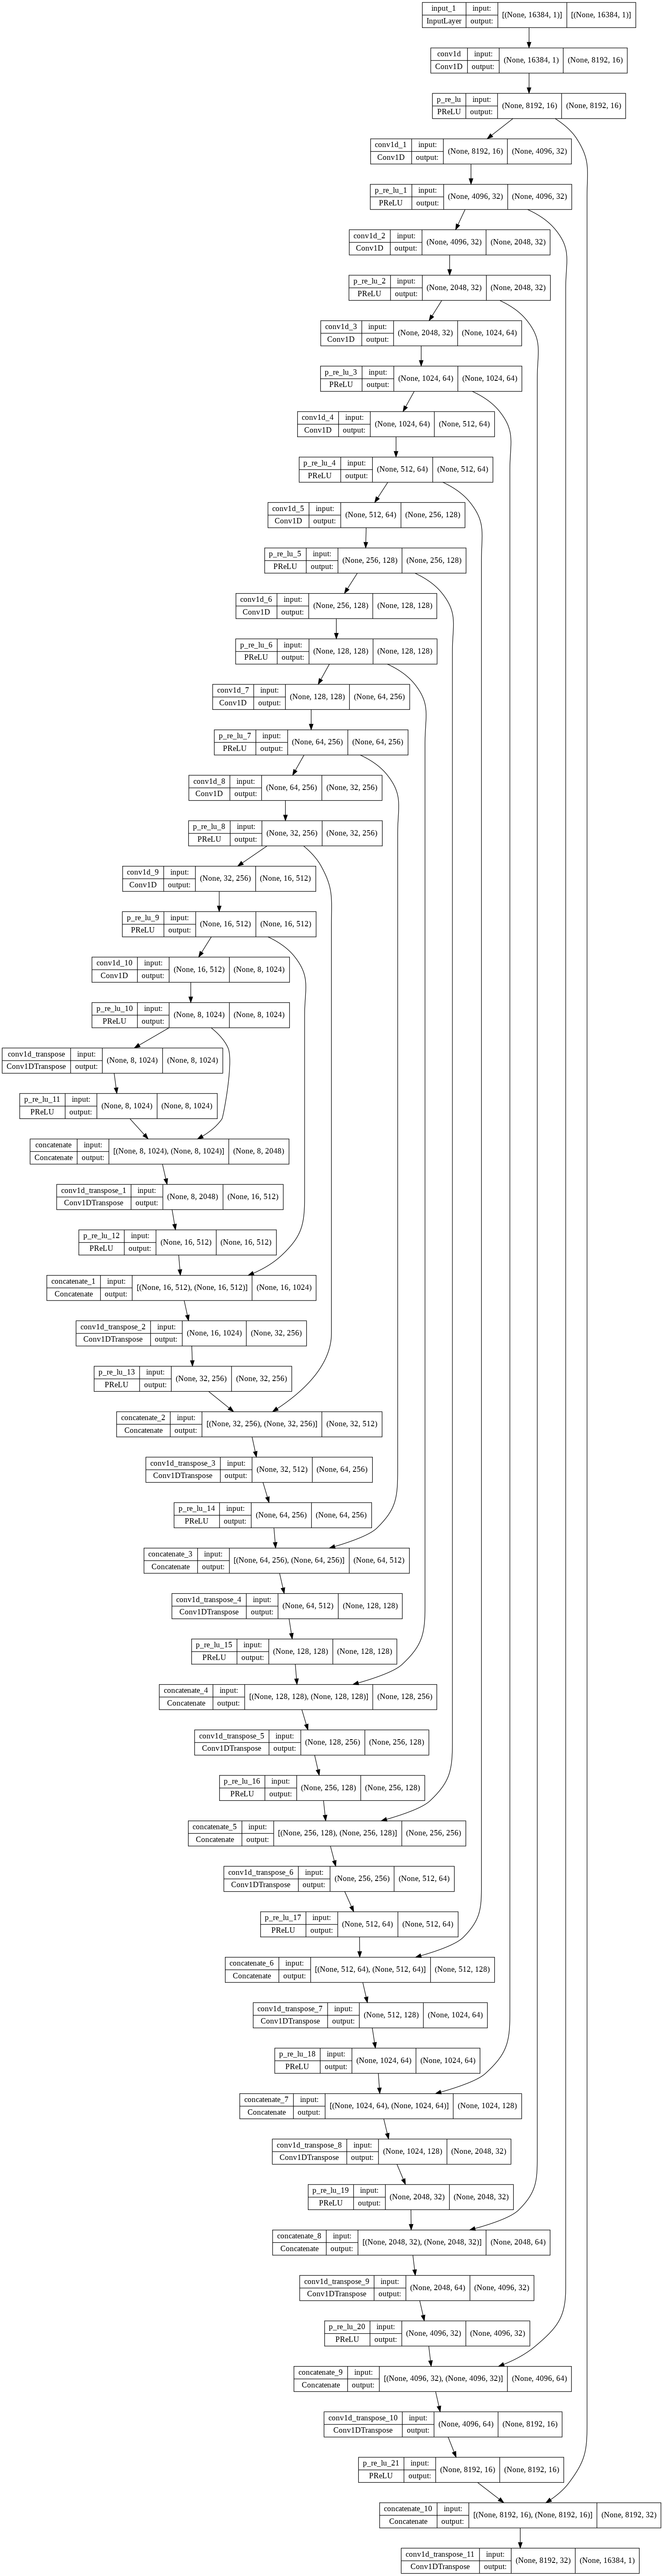

In [26]:
#Plot the model
plot_model(model=generator, show_shapes=True, show_layer_names=True)

##Discriminator

In [27]:
#Input layer : Two channels
input_clean = Input(shape=(BATCH_SIZE,1))
input_noisy = Input(shape=(BATCH_SIZE,1))
input = Concatenate()([input_clean,input_noisy])

#Convolutional layers
c1 = Conv1D(filters=16, kernel_size=31, strides=2, padding='same')(input)
c1n = BatchNormalization()(c1)
c1a = LeakyReLU(alpha=0.3)(c1n)

c2 = Conv1D(filters=32, kernel_size=31, strides=2, padding='same')(c1a)
c2n = BatchNormalization()(c2)
c2a = LeakyReLU(alpha=0.3)(c2n)

c3 = Conv1D(filters=32, kernel_size=31, strides=2, padding='same')(c2a)
c3n = BatchNormalization()(c3)
c3a = LeakyReLU(alpha=0.3)(c3n)

c4 = Conv1D(filters=64, kernel_size=31, strides=2, padding='same')(c3a)
c4n = BatchNormalization()(c4)
c4a = LeakyReLU(alpha=0.3)(c4n)

c5 = Conv1D(filters=64, kernel_size=31, strides=2, padding='same')(c4a)
c5n = BatchNormalization()(c5)
c5a = LeakyReLU(alpha=0.3)(c5n)

c6 = Conv1D(filters=128, kernel_size=31, strides=2, padding='same')(c5a)
c6n = BatchNormalization()(c6)
c6a = LeakyReLU(alpha=0.3)(c6n)

c7 = Conv1D(filters=128, kernel_size=31, strides=2, padding='same')(c6a)
c7n = BatchNormalization()(c7)
c7a = LeakyReLU(alpha=0.3)(c7n)

c8 = Conv1D(filters=256, kernel_size=31, strides=2, padding='same')(c7a)
c8n = BatchNormalization()(c8)
c8a = LeakyReLU(alpha=0.3)(c8n)

c9 = Conv1D(filters=256, kernel_size=31, strides=2, padding='same')(c8a)
c9n = BatchNormalization()(c9)
c9a = LeakyReLU(alpha=0.3)(c9n)

c10 = Conv1D(filters=512, kernel_size=31, strides=2, padding='same')(c9a)
c10n = BatchNormalization()(c10)
c10a = LeakyReLU(alpha=0.3)(c10n)

c11 = Conv1D(filters=1024, kernel_size=31, strides=2, padding='same')(c10a)
c11n = BatchNormalization()(c11)
c11a = LeakyReLU(alpha=0.3)(c11n)

c12 = Conv1D(filters=1, kernel_size=1, strides=1, padding='same')(c11a)
c12n = BatchNormalization()(c12)
c12a = LeakyReLU(alpha=0.3)(c12n)

#Flattening
flat = Flatten()(c12a)

#Fully-connected layer for final classification
d_output = Dense(units=1)(flat)

#Discriminator model
discriminator = Model(inputs=[input_clean, input_noisy], outputs=d_output)

In [28]:
#Summarize the model
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 16384, 1)]   0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 16384, 1)]   0           []                               
                                                                                                  
 concatenate_11 (Concatenate)   (None, 16384, 2)     0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 conv1d_11 (Conv1D)             (None, 8192, 16)     1008        ['concatenate_11[0][0]']   

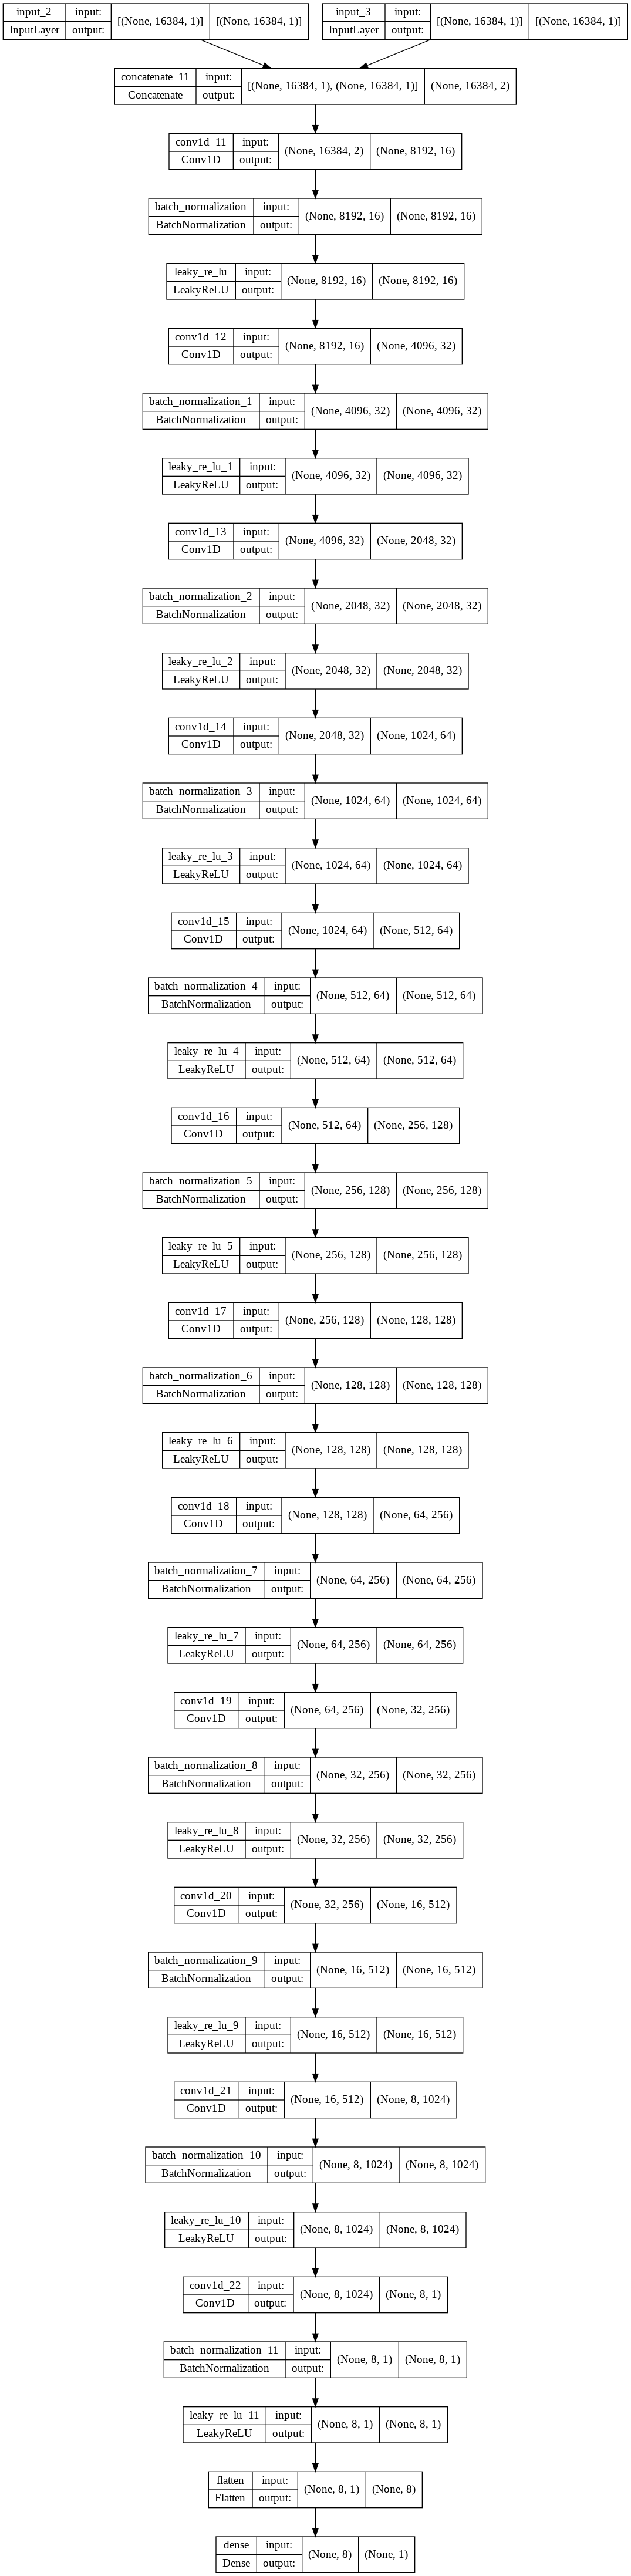

In [29]:
#Plot the mode
plot_model(model=discriminator, show_shapes=True, show_layer_names=True)

##GAN Model

In [30]:
loss_fn = BinaryCrossentropy(from_logits=True)

In [31]:
# Discriminator loss function using Binary Cross-entropy loss
def d_loss(d_real_output, d_generated_output):
  d_real_loss = loss_fn(tf.ones_like(d_real_output), d_real_output)
  d_generated_loss = loss_fn(tf.zeros_like(d_generated_output), d_generated_output)
  d_total_loss = d_real_loss + d_generated_loss
  return d_total_loss

In [32]:
# Generator loss function using Binary Cross-entropy loss
def g_loss(d_generated_output, g_output, real_signal, lamda):
  g_loss = loss_fn(tf.ones_like(d_generated_output), d_generated_output)
  regularisation_term = tf.reduce_mean(tf.abs(real_signal-g_output))
  g_total_loss = g_loss + (lamda*regularisation_term)
  return g_total_loss

In [41]:
# #Discriminator loss function using LSGAN (Least Squares GAN) approach
# def d_loss(d_real_output, d_generated_output):
#   d_real_loss = tf.reduce_mean(tf.math.squared_difference(d_real_output, 1))
#   d_generated_loss = tf.reduce_mean(tf.math.squared_difference(d_generated_output, 0))
#   d_total_loss = d_real_loss + d_generated_loss
#   return d_total_loss

In [42]:
# #Generator loss function using LSGAN (Least Squares GAN) approach
# def g_loss(d_generated_output, g_output, target, lamda):                        #target = clean signal
#   gan_loss = tf.reduce_mean(tf.math.squared_difference(d_generated_output, 1))
#   g_l1_loss = lamda * tf.reduce_mean(tf.abs(target,  g_output))
#   g_total_loss = gan_loss + g_l1_loss
#   return g_total_loss

In [33]:
#Optimizers
d_optimizer = Adam(learning_rate=0.0002)
g_optimizer = Adam(learning_rate=0.0002)

In [34]:
def mean_squared_error(model, input, target):
  prediction = model(input, training=True)
  mse = 0 
  mse = tf.reduce_mean(tf.math.squared_difference(target, prediction))
  # for i in range(prediction.shape[0]):
  #   mse = mse + tf.reduce_mean((target[i]-prediction[i])**2)
  # mse = mse/prediction.shape[0]
  return mse

In [35]:
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'prefix')
checkpoint = tf.train.Checkpoint(discriminator=discriminator, generator=generator, discriminator_optimizer=d_optimizer, generator_optimizer=g_optimizer)

log_dir = 'logs/fit/'

summary_writer = tf.summary.create_file_writer(logdir = log_dir + datetime.datetime.now().strftime('%Y_%m_%d-%H_%M_%S'))

In [36]:
EPOCHS = 20
LAMBDA = 100

In [37]:
def training_step(input, target, epoch):
  with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
    g_output = generator(input, training=True)
    d_real_output = discriminator([input, target], training=True)
    d_generated_output = discriminator([input, g_output], training=True)
    
    g_total_loss = g_loss(d_generated_output, g_output, target, LAMBDA)
    d_total_loss = d_loss(d_real_output, d_generated_output)

  g_gradients = g_tape.gradient(g_total_loss, generator.trainable_variables)
  d_gradients = d_tape.gradient(d_total_loss, discriminator.trainable_variables)

  g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))
  d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar(name='generator_loss', data=g_total_loss, step=epoch)
    tf.summary.scalar(name='discriminator_loss', data=d_total_loss, step=epoch)
  

In [38]:
def fit(epochs):
  for epoch in range(epochs):
    start = time.time()
    
    mse = 0
    for (input,target) in test_dataset.take(100):
      # latent = tf.random.normal(shape=(64,8,1024))
      mse = mse + mean_squared_error(generator, input, target)
    mse /= 100
    print('Epoch {} : mse = {}'.format(epoch+1, mse))

    for (input,target) in train_dataset:
      # latent = tf.random.normal(shape=(64,8,1024))
      training_step(input, target, epoch)
    
    end = time.time()
    print('Time taken for epoch {} is {} sec\n'.format(epoch+1, end-start))

    if (epoch+1)%5==0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
fit(EPOCHS)

In [46]:
Audio(np.squeeze(noisy_train[27000].numpy()), rate=16000)

In [47]:
Audio(tf.squeeze(generator.predict(tf.expand_dims(tf.expand_dims(noisy_train[27000], -1), 0))), rate=16000)